# Prepare Data

Author:  P. Lewis

Date:    Thu 25 Feb 2016

This section demonstrates the preparation of datasets for BRDF/albedo processing.

An example is used where we have *broadband* observation datasets from MERIS, SPOT VGT `['bbdr.meris', 'bbdr.vgt']` and MODIS (Terra and Aqua) `['mod09', 'myd09']`.

For testing other constraints, we also have different versions of a climatology (the 'prior') `['prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow']`.

For comparison, we also have the results from the GlobAlbedo processing chain `['ga.brdf.nosnow', 'ga.brdf.snow', 'ga.brdf.merge']`.

In [2]:
# load required libraries: you may need to install netCDF4
from defaults import *
%matplotlib inline

data directory /Users/plewis/Dropbox/CurrentGrants/QA4ECV_ATBD/data


In [5]:
datakeys = np.array(['bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])
# load the datasets into a dictionary in ncdata
ncdata = {}
for k in datakeys:
    try:
        ncdata[k] = load_obj('obj/'+ k + '_s3.0_' )
        print '3',k,
    except:
        print '2',k,
        ncdata[k] = load_obj('obj/'+ k + '_s2.0_' )        

2 bbdr.meris 2 bbdr.vgt 2 ga.brdf.merge 2 ga.brdf.nosnow 2 ga.brdf.snow 2 mod09 2 myd09 2 prior.v2.nosnow 2 prior.v2.snow 2 prior.v2.snownosnow


We next consider what time period we want to do mapping for.

Here, we start from the first date in the `bbdr.vgt` dataset and end on the last date of `mod09`.


In [3]:
d0,d1 = ncdata['bbdr.vgt']['date'][0],ncdata['mod09']['date'][-1]
print 'from',d0,'to',d1,'inclusive',
ndays = (d1-d0).days + 1
print 'which gives',ndays,'days'

from 1998-04-03 to 2016-01-01 inclusive which gives 6483 days


Define the wavebands of the dataset:

In [4]:
bands = np.array(['VIS','NIR','SW'])
nbands = bands.shape[0]

Now we pull out the parts of the dataset that we want access to, and structure them in convenient forms.

For `meris` and `vgt`, this is:

    reflectance:
        BB
        
    BRDF kernels:
        Isotropic 
        Kvol_BRDF
        Kgeo_BRDF
        
    Covariance matrix terms:
        sig_BB
        
All of these terms are spectral (i.e. defined for each waveband) (so, `BB_VIS` etc., `Kvol_BRDF_VIS` etc., `sig_BB_VIS_NIR` etc.).

Note that Isotropic is all ones (for valid samples), so this is provided during this reading, rather than loading it.

bbdr.meris bbdr.vgt ga.brdf.merge

KeyError: 'ga.brdf.merge'

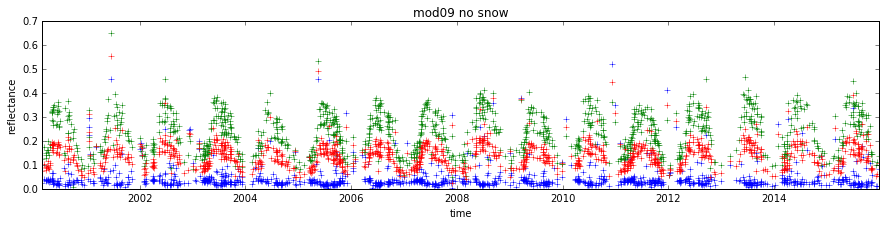

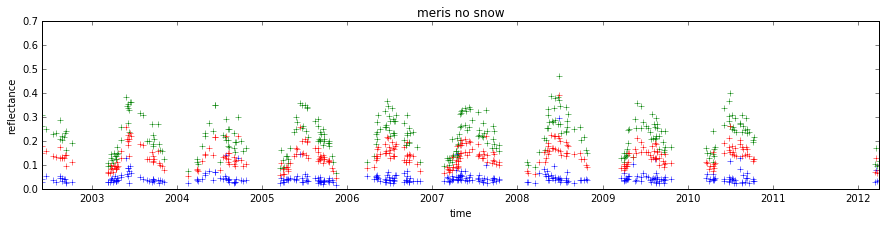

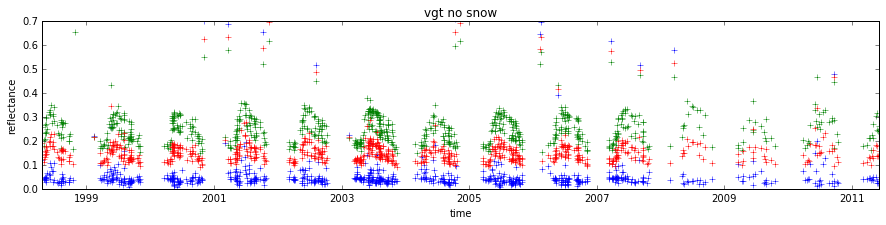

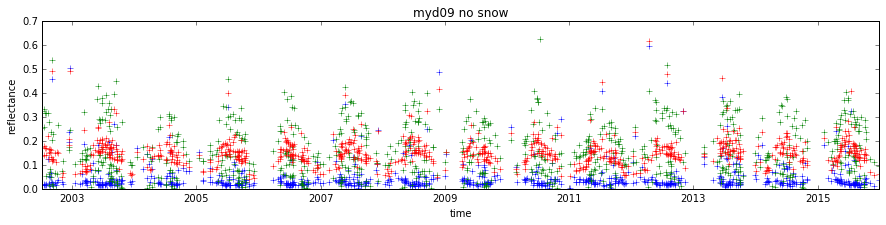

In [28]:
# pixel row col in dataset
r,c = 0,0

ncdata2 = {}

for m in ['mod09', 'meris','vgt',  'myd09']:
    plt.figure(figsize=(15,3))
    
    # ID the datazet
    try:
        dataset = ncdata['bbdr.%s'%m]
        ncdata2['bbdr.%s'%m] = dataset2 = {}
        # these are 3D datasets
        sl = (slice(None),r,c)
        sVis = '_BRDF_VIS'
        sNir = '_BRDF_NIR'
        sSw  = '_BRDF_SW'
        datatype = 'A'
        
    except:
        # these may be 1 D but need to fix
        dataset = ncdata[m]
        ncdata2[m] = dataset2 = {}
        sl = slice(None)
        sVis = sNir = sSw = ''
        datatype = 'B'
        
    # pull reflectance data
    refl = np.array([np.array(dataset['BB_VIS'])[sl],
                     np.array(dataset['BB_NIR'])[sl],
                     np.array(dataset['BB_SW'])[sl]])
    # identify dodgy values from refl
    # these data are shaped (nbands, nsamples)
    # If any of the nbands is False, we want to ignore all bands
    # so 
    mask = ((refl>0)*(refl<1)).prod(axis=0).astype(bool)
    try:
        # assuming dataset['mask'] is True for good data
        mask = np.logical_and(np.array(dataset['mask'])[sl],mask)
    except:
        pass
    # easiest to reload now ...
    refl = np.array([np.array(dataset['BB_VIS'])[sl][mask],
                     np.array(dataset['BB_NIR'])[sl][mask],
                     np.array(dataset['BB_SW'])[sl][mask]])

    # isotropic
    Isotropic = np.ones_like(dataset['Kvol%s'%sVis])
    # kernels
    kernels = np.array([[Isotropic[sl][mask],\
                         Isotropic[sl][mask],\
                         Isotropic[sl][mask]],\
                        [np.array(dataset['Kvol%s'%sVis])[sl][mask],\
                         np.array(dataset['Kvol%s'%sNir])[sl][mask],\
                         np.array(dataset['Kvol%s'%sSw])[sl][mask]],\
                        [np.array(dataset['Kgeo%s'%sVis])[sl][mask],\
                         np.array(dataset['Kgeo%s'%sNir])[sl][mask],\
                         np.array(dataset['Kgeo%s'%sSw])[sl][mask]]\
                       ])
    
    # uncertainty
    if datatype == 'A':
        var     = np.array([[np.array(dataset['sig_BB_VIS_VIS'])[sl][mask],\
                         np.array(dataset['sig_BB_VIS_NIR'])[sl][mask],\
                         np.array(dataset['sig_BB_VIS_SW'])[sl][mask]],\
                        [np.array(dataset['sig_BB_VIS_NIR'])[sl][mask],\
                         np.array(dataset['sig_BB_NIR_NIR'])[sl][mask],\
                         np.array(dataset['sig_BB_NIR_SW'])[sl][mask]],\
                        [np.array(dataset['sig_BB_VIS_SW'])[sl][mask],\
                         np.array(dataset['sig_BB_NIR_SW'])[sl][mask],\
                         np.array(dataset['sig_BB_SW_SW'])[sl][mask]]\
                       ])    

        weight = np.zeros_like(var)
        for i in xrange(refl.shape[-1]):
            try:
                weight[...,i] = np.matrix(var[...,i]).I
            except:
                pass
        del var
    elif datatype == 'B':
        w1 = [[dataset['weight_BB_VIS_VIS']]*len(mask),\
                            [dataset['weight_BB_NIR_VIS']]*len(mask),\
                            [dataset['weight_BB_SW_VIS']]*len(mask)]
        w2 = [[dataset['weight_BB_NIR_VIS']]*len(mask),\
                            [dataset['weight_BB_NIR_NIR']]*len(mask),\
                            [dataset['weight_BB_SW_NIR']]*len(mask)]
        w3 = [[dataset['weight_BB_SW_VIS']]*len(mask),\
                            [dataset['weight_BB_SW_NIR']]*len(mask),\
                            [dataset['weight_BB_SW_SW']]*len(mask)]
        weight = np.array([w1,w2,w3])  
        weight = weight[...,mask]

    date = dataset['date'][mask]        
    
    # store in dataset2
    dataset2['refl'] = refl.copy()
    dataset2['kernels'] = kernels.copy()
    dataset2['weight'] = weight.copy()
    dataset2['date'] = kernels.copy()
    dataset2['year'] = np.array(dataset['yeardoy'])[:,0]
    dataset2['doy'] = np.array(dataset['yeardoy'])[:,1]
    
    for i in xrange(nbands):
        plt.plot(date,refl[i],'+')
    plt.ylim(0,.7)
    plt.xlabel('time')
    plt.ylabel('reflectance')
    #plt.legend(loc='best')
    plt.title('%s no snow'%m)
    
# save as s3.0
for k in datakeys:
    try:
        print k,
        save_obj(ncdata2[k],k+'_s3.0_')
    except:
        pa

In [27]:
print np.array(dataset['date'])

want = ['yeardoy','mask*','weight*','date','reflectance']

[datetime.date(2002, 7, 5) datetime.date(2002, 7, 6)
 datetime.date(2002, 7, 7) ..., datetime.date(2015, 12, 30)
 datetime.date(2015, 12, 31) datetime.date(2016, 1, 1)]


## preparing the observation matrices

Define normalised inverse covariance (weighting) matrices $W_o$, associated with observational constraints, that are diagonal, and where each is normalised by its mean (scalar) value $w_o$ (so, if there were no difference in weighting, $W_o$ etc. would be the identity matrix $I$) and the scalar weight $w_o$ etc. is the *magnitude* of the constraint.

Let:

$$
    J_o = \frac{1}{2} w_o (y - K x)^T W_o (y - K x)
$$

Differentiation wrt $x$:

$$
    J'_o =  - w_o K^T W_o (y - K x) 
$$

and again:

$$
    J''_o =  - w_o K^T W_o K 
$$



setting the sum of derivatives to zero:

$$
    J' = 0 = - w_o K^T W_o (y - K x) 
$$

so

$$
     \left( w_o K^T W_o K  \right) x =  \left( w_o K^T W_o y \right)
$$

If we wish to map parameters in $n_{bands}$ for $n_{kernels}$ for $n_{days}$ locations, then the $x$ vector shape can be given as $(n_{kernels},n_{bands},n_{days}$).

In the above equations, we require $x$ to be vectorised: $vect(x)$, which has s hape  $(n_{bands} \times n_{kernels} \times n_{days}$).

so for index $(k,b,d)$ we have position $k \times (  n_{bands} \times n_{days} ) + b \times n_{days} + d$

The observations $y$ can be given shape $(n_{bands},n_{obs})$ but again, this is used in vectorised form $vect(y)$ which has shape $(n_{bands} \times n_{obs})$.

The weighting matrix $W_o$ is $(n_{bands} \times n_{obs},n_{bands} \times n_{obs})$ but is sparse as the uncertainty is only correlated across wavebands, so is stroed in blocks.

The kernel matrix $K$ consists of sub-blocks of $(n_{bands} \times n_{kernels},n_{bands})$ so $(9,3)$ here.

In [ ]:
# how to stack the kernel blocks

nbands = len(bands)
nk = 3
alldoys = np.arange(ndays)

m = 'bbdr.meris'
tmp = scipy.sparse.lil_matrix((nk*nbands,nbands))
mask = ncdata[m]['obs mask']
n = mask.shape[0]
kk = (ncdata[m]['kernels'].reshape(nk*nbands,n))[:,mask][:,0]
thisk = kk.reshape(nk,nbands).T
for p in xrange(nbands):
    tmp[p*nk:(p+1)*nk,p] = np.atleast_2d(thisk[p]).T
print tmp.todense().shape
print tmp.todense()

In [ ]:
b = {}
A = {}
sdoys = {}

# full ones
bp = {}
Ap = {}
sdoysp = {}

for i,m in enumerate(['bbdr.meris','bbdr.vgt','mod09','myd09']):
#for i,m in enumerate(['mod09']):
    print m
    mask = ncdata['%s'%m]['obs mask']
    n = mask.shape[0]
    nobs = mask.sum()
    doys = ncdata['%s'%m]['days']
    
    # kernels are shaped kernels[k][band][day]
    kernels = ncdata['%s'%m]['kernels']
    
    # refl are shaped refl[band][day]
    refl = np.array([ncdata['%s'%m]['refl']]).squeeze()
    refl[np.isnan(refl)] = 0.
    
    # weight are shaped weight[k][band][day]
    if ncdata['%s'%m]['obs weight'].ndim == 3:
        weight = ncdata['%s'%m]['obs weight']
    else:
        weight = np.array([ncdata['%s'%m]['obs weight'].flatten()]*n).T.reshape(kernels.shape)
    kernels = kernels[:,:,mask]
    refl    = refl[:,mask]
    weight  = weight[:,:,mask]
    doys    = doys[mask]
    print kernels.shape,refl.shape,weight.shape
    # in essence its easiest to loop over all observations
    # since they are independent
    AA = []
    bb = []
    dd = []
    
    # full size sparse arrays
    AAp = scipy.sparse.lil_matrix((nk*nbands*ndays,nk*nbands*ndays))
    bbp = scipy.sparse.lil_matrix((nk*nbands*ndays,1))
    ddp = np.arange(ndays)
    
    for p in xrange(nobs):
        # pull out the individual pixels
        
        # sort the (9,3) K matrix term
        # K (9,3)
        tmp = scipy.sparse.lil_matrix((nk*nbands,nbands))
        n = mask.shape[0]
        kk = (ncdata[m]['kernels'].reshape(nk*nbands,n))[:,mask][:,p]
        thisk = kk.reshape(nk,nbands).T
        for q in xrange(nbands):
            tmp[q*nk:(q+1)*nk,q] = np.atleast_2d(thisk[q]).T
        # tmp is the sub-kernel matrix
        # This part is checked and is correct
        # it operates as in code example above
            
        # pull out the weight and reflectance for pixel p
        # and find the day ID for this sample
        refl_    = refl[:,p]
        weight_  = weight[:,:,p]
        weight_ = np.eye(nbands)
        doy      = doys[p]
        #import pdb;pdb.set_trace()
        # weight is e.g.:
        #
        # array([[ 102.86963654,   13.86234665,  -35.25061035],
        # [  13.86234665,   77.44153595,  -48.78294373],
        # [ -35.25061035,  -48.78294373,  124.05032349]], dtype=float32)
        #
        # which is the observation uncertainty matrix
        # we notice there are strong between band
        # correlations in uncertainty very often
        
        # calculate the relevant part of the A matrix
        # for this observation
        # This will be a (9,9) matrix
        # with all positive elements on
        # the leading diagonal
        # eg
        # array([ 102.86963654,    0.61776894,  147.35500157,   77.44153595,
        #  0.85568291,  113.19379327,  124.05032349,    1.02452569,
        # 180.67130031])
        #
        # Note that the weight terms appear in here
        # because the first kernel is 1
        # so A_ is structured 
        # [b0k0,b0k1,b0k2,  b1k0,b1k1,b1k2,  b2k0,b2k1,b2k2]
        # i.e. index = band * nk + k
        # A_ is the individual sample A matrix
        # and is (9,9)
        A_ = tmp * np.matrix(weight_) * tmp.T
        # b_ is a vector of size (9,)
        # e.g. 
        # matrix([[  1.23429494],[ -0.09565075],[ -1.47726289],
        # [ 13.3686551 ],[ -1.40526157],[-16.16263059],
        # [  4.72319433],[ -0.42923813],[ -5.70008653]])
        
        # array([  1.23429494,  -0.09565075,  -1.47726289,  13.3686551 ,
        # -1.40526157, -16.16263059,   4.72319433,  -0.42923813,  -5.70008653])
        #
        # This is built from e.g.:
        #
        # weight is e.g.:
        # array([[ 102.86963654,   13.86234665,  -35.25061035],
        # [  13.86234665,   77.44153595,  -48.78294373],
        # [ -35.25061035,  -48.78294373,  124.05032349]], dtype=float32)
        #
        # eg refl =
        # array([ 0.02774778,  0.26135752,  0.14873891], dtype=float32)
        #
        # weight_ * refl_
        # matrix([[  1.23429489],[ 13.36865425],[  4.72319412]], dtype=float32)
        #
        # which is simply the weighted reflectance, e.g.
        # 1.2342952249224695 = 
        # 0.02774778 * 102.86963654 + 0.26135752 * 13.86234665 + 0.14873891 *-35.25061035
        # Note that the weighted reflectance terms
        # directly appear in b_ every 3 items because k0 is 1.0
        # 
        b_ = np.array(tmp * np.matrix(weight_) * np.matrix(refl_).T).flatten() 
        # [b0 k0, b0 k1, b0 k2, b1 k0, b1 k1 , ...]
        
        # append the individual matrices onto AA,bb,dd
        AA.append(A_)
        bb.append(b_)
        dd.append(doy)
        # load in the big one
        # full padding  ... add terms to block in doy slot  
        # 
        # The full matrix of A is (nbands*nk*nday, nbands*nk*nday)
        # and b is (nbands*nk*nday,1)
        #
        # The indexing is:
        # index = (d * nbands * nk) + (band*nk) + k
        # so
        for band in xrange(nbands):
            for k in xrange(nk):
                index = (doy * nbands * nk) + (band*nk) + k
                bbp[index,0] += b_[(band*nk) + k]
                for band2 in xrange(nbands):
                    for k2 in xrange(nk):
                        index2 = (doy * nbands * nk) + (band2*nk) + k2
                        AAp[index,index2] += A_[(band*nk) + k,(band2*nk) + k2]
        # This is the slow way to load the matrix, but we can be sure of its operation
        # should implement a faster multi-element load
    sdoysp[m] = ddp
    Ap[m] = AAp
    bp[m] = bbp
    
    # save the individual matrices in 
    # a dictionary
    sdoys[m] = np.array(dd)
    A[m] = np.array(AA)
    b[m] = np.array(bb)   
    

# store results
for k in A.keys():
    print 'storing ...',k,
    Ab = {'A':A[k],'b':b[k],'doys':sdoys[k]}
    save_obj(Ab,'Ab_store_obs_%s'%k)
    Ab = {'A':Ap[k],'b':bp[k],'doys':sdoysp[k]}
    save_obj(Ab,'Ab_store_%s'%k)
print 'done'

In [ ]:
print type(weight_)
k = 'mod09'
Ab = {'A':A[k],'b':b[k],'doys':sdoys[k]}
Ab['A'][0]

## prepare derivative

In [ ]:
# form a D matrix -- should replace by sparse
I = np.eye(ndays)
D = np.matrix(I - np.roll(I,-1))
D2 = D * D.T

# form a D matrix -- should replace by sparse
D = np.matrix(I - np.roll(I,-365))
D2365 = D * D.T

In [ ]:
D2 = scipy.sparse.lil_matrix(D2)
D2365 = scipy.sparse.lil_matrix(D2365)
print D2.todense()
print D2365.todense()

In [ ]:
# make a big A matrix
AD = scipy.sparse.lil_matrix(Ap[k].shape)
bD = scipy.sparse.lil_matrix((Ap[k].shape[0],1))

# make a big A matrix
AD365 = scipy.sparse.lil_matrix(Ap[k].shape)
bD365 = scipy.sparse.lil_matrix((Ap[k].shape[0],1))
print AD.shape,bD.shape

In [ ]:
steps = nbands * nk
for i in xrange(steps):
    AD[i::steps,i::steps] = D2
    AD365[i::steps,i::steps] = D2365

In [ ]:
k = 'D1'
Ab = {'A':AD,'b':bD,'doys':np.arange(ndays)}
save_obj(Ab,'Ab_store_%s'%k)
k = 'D365'
Ab = {'A':AD365,'b':bD365,'doys':np.arange(ndays)}
save_obj(Ab,'Ab_store_%s'%k)

## preparing the prior matrices


Let:

$$
    J_p = \frac{1}{2} w_p (x_p - x)^T W_p (x_p - x)
$$

Differentiation wrt $x$:

$$
    J'_p = - w_p W_p (x_p - x)
$$

and


$$
    J''_p = w_p W_p
$$

The prior data are only sampled every 8 days.

$x_p$ is the prior mean which can be given the shape $(n_{bands},46,n_{kernels})$

The weighting matrix $W_o$ is $(n_{bands} \times n_{kernels} \times n_{days},n_{bands} \times n_{kernels}\times n_{days})$ but is sparse, and diagonal.



In [ ]:
pps = ['prior.v2.snow' ,'prior.v2.nosnow']

for pp in pps:

    prior = ncdata[pp]

    # mean
    mean = []
    for b in bands:
        m = np.array(prior['Mean_%s'%b]).squeeze().reshape(nk,46)
        mean.append(m)
    mean = np.array(mean)
    print mean.shape

    # var -> weight
    kk = ['f%d'%i for i in xrange(nk)]
    var = [[]]*nbands
    for band in xrange(nbands):
        var[band] = []
        for p,f0 in enumerate(kk):
            cc = np.array(prior['Cov_%s_%s_%s_%s'%(bands[band],f0,bands[band],f0)]).squeeze()
            var[band].append(cc)  
    var = np.array(var)
    weight = 1./var
    weight = weight/scale
    print weight.shape
    # these are formed 
    xp = np.zeros((nbands*nk*ndays))
    Wp = np.zeros((nbands*nk*ndays))
    
    for d in xrange(ndays):
        thisd = d0 + timedelta(d)
        thisdoy = ((thisd - date(thisd.year,1,1)).days)/8
        for k in xrange(nk): 
            xp[d*nbands*nk+k*nbands:d*nbands*nk+(k+1)*nbands] = mean[:,k,thisdoy]
            Wp[d*nbands*nk+k*nbands:d*nbands*nk+(k+1)*nbands] = weight[:,k,thisdoy]
    Ap = scipy.sparse.diags(Wp,0)
    bp = Ap * scipy.sparse.lil_matrix(xp).T
    Ab = {'A':Ap,'b':bp}
    save_obj(Ab,'Ab_store_%s'%pp)

In [ ]:
# visualise the mean and sd
colour = ['r','g','b']

for band in xrange(nbands):
    for k in xrange(nk):
        xx = xp[k*nbands+band::nbands*nk]
        wx = Wp[k*nbands+band::nbands*nk]

        # make an x array for plotting
        x = np.array([np.array([[timedelta(i)+d0 \
                    for i in np.arange(ndays)]]).T]).T.squeeze()

        # yerr for this band for the 3 kernels
        yerr = np.sqrt(1./wx)/np.sqrt(scale)

        plt.figure(figsize=(15,2))
        plt.errorbar(x, xx, c='%s'%colour[k], yerr=yerr)
        plt.plot(x,xx,'k+',label=kk[k])
        plt.title('band %s kernel %s'%(bands[band],kk[k]))
        plt.xlabel('doy')
        plt.ylabel('kernel mean')
